In [1]:
pip install torchfile

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install timm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import timm
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2 as cv
from PIL import Image
import torchfile

from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm
from torch.nn import functional as F

/home/sakshi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
!wget http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz

--2025-01-07 15:03:42--  http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz [following]
--2025-01-07 15:03:44--  https://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541127779 (516M) [application/x-gzip]
Saving to: ‘vgg_face_torch.tar.gz.3’

vgg_face_torch.tar. 100%[===================>] 516.06M  12.3MB/s    in 47s     

2025-01-07 15:04:31 (11.0 MB/s) - ‘vgg_face_torch.tar.gz.3’ saved [541127779/541127779]



In [5]:
!tar -xvf vgg_face_torch.tar.gz

vgg_face_torch/
vgg_face_torch/._ak.png
vgg_face_torch/ak.png
vgg_face_torch/._COPYING
vgg_face_torch/COPYING
vgg_face_torch/demo.lua
vgg_face_torch/names.txt
vgg_face_torch/._README
vgg_face_torch/README
vgg_face_torch/VGG_FACE.t7


In [6]:
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        super().__init__()
        
        self.root_dir = root_dir
        self.transform = transform
        self.filename_list = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.filename_list)
    
    def age_to_class(self, age):
        range_ages = [0, 4, 9, 15, 25, 35, 45, 60, 75]
        if age > max(range_ages):
                return len(range_ages) - 1
        for i in range(len(range_ages) - 1):
            if range_ages[i] <= age <= range_ages[i + 1]:
                return i
    
    def __getitem__(self, idx):
        filename = self.filename_list[idx]
        
        info = filename.split("_")
        age = int(info[0])
        age_label = self.age_to_class(age)
        gender = int(info[1])
        
        filename = os.path.join(self.root_dir, filename)
        
        image = Image.open(filename)
        
        if self.transform:
            image = self.transform(image)
        
        return image, gender, age_label, age

In [7]:
class GenderModel(nn.Module):
    "VGG-Face"
    def __init__(self):
        super().__init__()
        self.conv_1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv_2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv_3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc6 = nn.Linear(2048, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 1)

    
    def forward(self, x):
        """ Pytorch forward

        Args:
            x: input image (224x224)

        Returns: class logits

        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, self.training)
        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5, self.training)
        return F.sigmoid(self.fc8(x))
    

class AgeRangeModel(nn.Module):
    def __init__(self, in_channels = 3, backbone = 'resnet50', pretrained = False, num_classes = 9):
        super().__init__()
        
        self.Conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2),             
        )
    
        self.Conv2 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2), 
        )
        
        self.Conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2), 
        )
        self.adap = nn.AdaptiveAvgPool2d((2,2))
        
        self.out_age = nn.Sequential(
            nn.Linear(2048, num_classes)
#             nn.Softmax(dim = 1)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        
        x = self.adap(x)
        
        x = x.view(batch_size, -1)
        
        x = self.out_age(x)
    
        return x
    
class AgeEstimationModel(nn.Module):
    "VGG-Face"
    def __init__(self):
        super().__init__()
        self.embedding_layer = nn.Embedding(9, 9)
        
        self.Conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2),             
        )
    
        self.Conv2 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2), 
        )
        
        self.Conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(2), 
        )

        self.adap = nn.AdaptiveAvgPool2d((2,2))
        
        self.out_age = nn.Sequential(
            nn.Linear(2048 + 9, 1),
            nn.ReLU()
        )
        
    def forward(self, x, y):
        batch_size = x.shape[0]
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        
        x = self.adap(x)
        
        x = x.view(batch_size, -1)
        
        y = self.embedding_layer(y)
        
        x = torch.cat([x,y], dim = 1)
        
        x = self.out_age(x)
    
        return x

In [8]:
def split_dataloader(train_data, validation_split = 0.2):
    # Chia DataLoader thành phần train và test
    train_ratio = 1 - validation_split  # Tỷ lệ phần train (80%)
    train_size = int(train_ratio * len(train_data.dataset))  # Số lượng mẫu dùng cho train

    indices = list(range(len(train_data.dataset)))  # Danh sách các chỉ số của dataset
    train_indices = indices[:train_size]  # Chỉ số của mẫu dùng cho train
    val_indices = indices[train_size:]  # Chỉ số của mẫu dùng cho test

    # lấy dữ liệu từ dataloader
    dataset = train_data.dataset
    batch_size = train_data.batch_size
    num_workers = train_data.num_workers
    
    # Tạo ra các SubsetRandomSampler để chọn một phần dữ liệu cho train và test
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Tạo DataLoader mới từ SubsetRandomSampler
    train_data = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers, drop_last = True)
    val_data = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = num_workers, drop_last = True)
    
    return train_data, val_data


In [9]:

def evaluate(gender_model, age_range_model, age_estimation_model, val_dataloader, device = 'cpu', weights = None, verbose = 0):
    # set device
    if isinstance(device, str):
        if (device == 'cuda' or device == 'gpu') and torch.cuda.is_available():
            device = torch.device(device)
        else:
            device = torch.device('cpu')

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')

    # Loss function
    AgeRangeLoss = nn.CrossEntropyLoss()
    GenderLoss = nn.BCELoss()
    AgeEstimationLoss = nn.L1Loss()
    
    gender_model = gender_model.to(device)
    age_range_model = age_range_model.to(device)
    age_estimation_model = age_estimation_model.to(device)

    with torch.no_grad():
        age_range_model.eval()
        gender_model.eval()
        age_estimation_model.eval()
        age_accuracy = 0
        gender_accuracy = 0
        total_age_loss = 0
        total_gender_loss = 0
        total_age_estimation_loss = 0
        if verbose == 1:
            val_dataloader = tqdm(val_dataloader, desc = 'Evaluate: ', ncols = 100)
            
        for images, genders, age_labels, ages in val_dataloader:
            batch_size = images.shape[0]
            
            images, genders, age_labels, ages = images.to(device), genders.to(device), age_labels.to(device), ages.to(device)
            
            pred_genders = gender_model(images).view(-1)
            pred_age_labels = age_range_model(images)
                        
            age_loss = AgeRangeLoss(pred_age_labels, age_labels.long())
            gender_loss = GenderLoss(pred_genders, genders.float())
            
            total_age_loss += age_loss.item()
            total_gender_loss += gender_loss.item()

            gender_acc = torch.sum(torch.round(pred_genders) == genders)/batch_size
            age_acc = torch.sum(torch.argmax(pred_age_labels, dim = 1) == age_labels)/batch_size
            
            age_accuracy += age_acc
            gender_accuracy += gender_acc
            
            estimated_ages  = age_estimation_model(images, age_labels).view(-1)
            age_estimation_loss = AgeEstimationLoss(ages, estimated_ages)
            
            total_age_estimation_loss += age_estimation_loss.item()
            
        average_age_loss = total_age_loss / len(val_dataloader)
        average_gender_loss = total_gender_loss / len(val_dataloader)
        age_accuracy = age_accuracy / len(val_dataloader)
        gender_accuracy = gender_accuracy / len(val_dataloader)
        val_age_estimation_loss = total_age_estimation_loss / len(val_dataloader)
        return average_age_loss, average_gender_loss, age_accuracy, gender_accuracy, val_age_estimation_loss

In [10]:
def train(gender_model, age_range_model, age_estimation_model, train_data, device = 'cpu', weights = None, num_epochs = 50, steps_per_epoch = None,
              validation_data = None, validation_split = None, save_last_weights = None):
    
    # đặt validation_data and validation_split không đồng thời khác None
    assert not(validation_data is not None and validation_split is not None)

    if isinstance(device, str):
        if (device == 'cuda' or device == 'gpu') and torch.cuda.is_available():
            device = torch.device(device)
        else:
            device = torch.device('cpu')

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')

    # chia dữ liệu thành 2 tập train và val    
    if validation_data is not None:
        val_data = validation_data
    elif validation_split is not None: 
        train_data, val_data = split_dataloader(train_data, validation_split)
    else: 
        val_data = None 

    # if steps_per_epoch is None:
    #     steps_per_epoch = len(train_data)
        
    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1

    # Optimizer
    gen_optimizer = torch.optim.Adam(gender_model.parameters(), lr = 1e-4)
    age_range_optimizer = torch.optim.Adam(age_range_model.parameters(), lr = 5e-3)
    age_estimation_optimizer = torch.optim.Adam(age_estimation_model.parameters(), lr = 1e-3)
    
    # history
    history = {
        'train_gender_loss': [],
        'train_age_range_loss': [],
        'train_gender_acc': [],
        'train_age_range_acc': [],
        'val_gender_loss': [],
        'val_age_range_loss': [],
        'val_gender_acc': [],
        'val_age_range_acc': [],
        'train_age_estimation_loss': [],
        'val_age_estimation_loss': []
    }

    # Loss function
    AgeRangeLoss = nn.CrossEntropyLoss()
    GenderLoss = nn.BCELoss()
    AgeEstimationLoss = nn.L1Loss()

    age_range_scheduler = ReduceLROnPlateau(age_range_optimizer, mode = 'min', factor = 0.1, patience = 3, verbose = 1)
    gender_scheduler = ReduceLROnPlateau(gen_optimizer, mode = 'min', factor = 0.1, patience = 3, verbose = 1)
    age_estimation_scheduler = ReduceLROnPlateau(age_estimation_optimizer, mode = 'min', factor = 0.1, patience = 3, verbose = 1)
    
    for epoch in range(1, num_epochs + 1):
        total_gender_loss = 0
        total_age_loss = 0 
        age_accuracy = 0
        gender_accuracy = 0
        
        total_age_estimation_loss = 0
        
        gender_model.train()
        age_range_model.train()
        age_estimation_model.train()
        
        for step in tqdm(range(steps_per_epoch), desc = f'Epoch {epoch}/{num_epochs}: ', ncols = 100):
            images, genders, age_labels, ages = next(iterator)
            batch_size = images.shape[0]
            
            images, genders, age_labels, ages = images.to(device), genders.to(device), age_labels.to(device), ages.to(device)

            pred_genders = gender_model(images).view(-1)
            pred_age_labels = age_range_model(images)
            
            age_loss = AgeRangeLoss(pred_age_labels, age_labels.long())
            
            gender_loss = GenderLoss(pred_genders, genders.float())
                        
            total_age_loss += age_loss.item()
            total_gender_loss += gender_loss.item()
            
            gender_acc = torch.sum(torch.round(pred_genders) == genders)/batch_size
            age_acc = torch.sum(torch.argmax(pred_age_labels, dim = 1) == age_labels)/batch_size
            
            age_accuracy += age_acc
            gender_accuracy += gender_acc
            
            age_range_optimizer.zero_grad()
            age_loss.backward()
            age_range_optimizer.step()

            gen_optimizer.zero_grad()
            gender_loss.backward()
            gen_optimizer.step()
            # age estimation loss
            
            estimated_ages = age_estimation_model(images, age_labels).view(-1)
            age_estimation_loss = AgeEstimationLoss(ages, estimated_ages)
            
            age_estimation_optimizer.zero_grad()
            age_estimation_loss.backward()
            age_estimation_optimizer.step()
            
            total_age_estimation_loss += age_estimation_loss.item()
            
            
            # nếu nó duyệt hết qua tập dữ liệu thì cho nó lặp lại 1 lần nữa
            if count_steps == num_steps:
                iterator = iter(train_data)
                count_steps = 0
            count_steps += 1
            
        train_age_loss = total_age_loss / steps_per_epoch
        train_gender_loss = total_gender_loss / steps_per_epoch
        train_age_accuracy = age_accuracy / steps_per_epoch
        train_gender_accuracy = gender_accuracy / steps_per_epoch

        train_age_estimation_loss = total_age_estimation_loss/steps_per_epoch

        history['train_age_range_loss'].append(float(train_age_loss))
        history['train_gender_loss'].append(float(train_gender_loss))
        history['train_age_range_acc'].append(float(train_age_accuracy))
        history['train_gender_acc'].append(float(train_gender_accuracy))
        history['train_age_estimation_loss'].append(float(train_age_estimation_loss))


        
        print(f'train_age_loss: {train_age_loss: .2f}, train_gender_loss: {train_gender_loss: .3f}, train_age_accuracy: {train_age_accuracy: .2f}, train_gender_accuracy: {train_gender_accuracy: .2f}, train_age_estimation_loss: {train_age_estimation_loss: .3f}')
        
        if val_data:
            val_age_loss, val_gender_loss, val_age_accuracy, val_gender_accuracy, val_age_estimation_loss = evaluate(gender_model, age_range_model, age_estimation_model, val_data, device = device)
            history['val_age_range_loss'].append(float(val_age_loss))
            history['val_gender_loss'].append(float(val_gender_loss))
            history['val_age_range_acc'].append(float(val_age_accuracy))
            history['val_gender_acc'].append(float(val_gender_accuracy))
            history['val_age_estimation_loss'].append(float(val_age_estimation_loss))
            
            age_range_scheduler.step(np.round(val_age_loss, 3))
            gender_scheduler.step(np.round(val_gender_loss, 3))
            age_estimation_scheduler.step(np.round(val_age_estimation_loss, 3))
            print(f'val_age_loss: {val_age_loss: .2f}, val_gender_loss: {val_gender_loss: .3f}, val_age_accuracy: {val_age_accuracy: .2f}, val_gender_accuracy: {val_gender_accuracy: .2f}, val_age_estimation_loss: {val_age_estimation_loss : .3f}')

    if save_last_weights:  
        torch.save(model.state_dict(), save_last_weights)
        print(f'Saved successfully last weights to:', save_last_weights)
    return history


In [11]:
image_size = (64, 64)
num_workers = os.cpu_count()
batch_size = 512
device = 'cuda'
save_weights = 'AgeGenderWeights2.pt'
weights = 'AgeGenderWeights2.pt'
root_dir = '/home/sakshi/ACL_Resources/PyTorch-Gender & Age Detection/Dataset/UTKFace'

In [12]:
train_transform = T.Compose(
    [
        T.Resize(image_size),
        T.RandomHorizontalFlip(0.5),
        T.ToTensor(),
        T.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
    ]
)

train_dataset = UTKFaceDataset(root_dir, transform = train_transform)
dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers, drop_last = True)
trainloader, valloader = split_dataloader(dataloader)

In [13]:
# add model to device
device = torch.device('cuda'  if torch.cuda.is_available() else 'cpu')
gender_model = GenderModel().to(device)
age_range_model = AgeRangeModel().to(device)
age_estimation_model = AgeEstimationModel().to(device)

In [15]:


history = train(gender_model, age_range_model, age_estimation_model, trainloader, num_epochs = 10, device = device, steps_per_epoch = 5, validation_split = None, validation_data = valloader, save_last_weights = None)



Epoch 1/10: 100%|█████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.40s/it]

train_age_loss:  3.84, train_gender_loss:  0.693, train_age_accuracy:  0.20, train_gender_accuracy:  0.52, train_age_estimation_loss:  17.941


val_age_loss:  3.04, val_gender_loss:  0.691, val_age_accuracy:  0.33, val_gender_accuracy:  0.53, val_age_estimation_loss:  27.045


Epoch 2/10: 100%|█████████████████████████████████████████████████████| 5/5 [03:13<00:00, 38.62s/it]

train_age_loss:  2.90, train_gender_loss:  0.692, train_age_accuracy:  0.27, train_gender_accuracy:  0.52, train_age_estimation_loss:  14.995


val_age_loss:  2.34, val_gender_loss:  0.692, val_age_accuracy:  0.23, val_gender_accuracy:  0.53, val_age_estimation_loss:  22.786


Epoch 3/10: 100%|█████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.17s/it]

train_age_loss:  2.34, train_gender_loss:  0.691, train_age_accuracy:  0.22, train_gender_accuracy:  0.54, train_age_estimation_loss:  14.711


val_age_loss:  2.14, val_gender_loss:  0.691, val_age_accuracy:  0.16, val_gender_accuracy:  0.53, val_age_estimation_loss:  18.140


Epoch 4/10: 100%|█████████████████████████████████████████████████████| 5/5 [03:18<00:00, 39.66s/it]

train_age_loss:  2.08, train_gender_loss:  0.694, train_age_accuracy:  0.30, train_gender_accuracy:  0.51, train_age_estimation_loss:  14.340


val_age_loss:  2.03, val_gender_loss:  0.692, val_age_accuracy:  0.30, val_gender_accuracy:  0.53, val_age_estimation_loss:  16.509


Epoch 5/10: 100%|█████████████████████████████████████████████████████| 5/5 [03:14<00:00, 38.85s/it]

train_age_loss:  1.99, train_gender_loss:  0.692, train_age_accuracy:  0.26, train_gender_accuracy:  0.53, train_age_estimation_loss:  14.352


val_age_loss:  1.91, val_gender_loss:  0.692, val_age_accuracy:  0.31, val_gender_accuracy:  0.53, val_age_estimation_loss:  15.809


Epoch 6/10: 100%|█████████████████████████████████████████████████████| 5/5 [03:13<00:00, 38.68s/it]

train_age_loss:  1.89, train_gender_loss:  0.693, train_age_accuracy:  0.33, train_gender_accuracy:  0.51, train_age_estimation_loss:  14.055


val_age_loss:  1.92, val_gender_loss:  0.692, val_age_accuracy:  0.30, val_gender_accuracy:  0.53, val_age_estimation_loss:  15.158


Epoch 7/10: 100%|█████████████████████████████████████████████████████| 5/5 [03:19<00:00, 39.97s/it]

train_age_loss:  1.91, train_gender_loss:  0.692, train_age_accuracy:  0.29, train_gender_accuracy:  0.53, train_age_estimation_loss:  14.038


val_age_loss:  1.83, val_gender_loss:  0.692, val_age_accuracy:  0.34, val_gender_accuracy:  0.53, val_age_estimation_loss:  14.835


Epoch 8/10: 100%|█████████████████████████████████████████████████████| 5/5 [03:14<00:00, 38.92s/it]

train_age_loss:  1.86, train_gender_loss:  0.693, train_age_accuracy:  0.34, train_gender_accuracy:  0.51, train_age_estimation_loss:  13.868


val_age_loss:  1.85, val_gender_loss:  0.692, val_age_accuracy:  0.33, val_gender_accuracy:  0.53, val_age_estimation_loss:  14.487


Epoch 9/10: 100%|█████████████████████████████████████████████████████| 5/5 [03:08<00:00, 37.77s/it]

train_age_loss:  1.89, train_gender_loss:  0.693, train_age_accuracy:  0.32, train_gender_accuracy:  0.52, train_age_estimation_loss:  14.363


val_age_loss:  1.82, val_gender_loss:  0.692, val_age_accuracy:  0.34, val_gender_accuracy:  0.53, val_age_estimation_loss:  14.576


Epoch 10/10: 100%|████████████████████████████████████████████████████| 5/5 [03:08<00:00, 37.63s/it]

train_age_loss:  1.88, train_gender_loss:  0.693, train_age_accuracy:  0.32, train_gender_accuracy:  0.52, train_age_estimation_loss:  13.928


val_age_loss:  1.80, val_gender_loss:  0.692, val_age_accuracy:  0.35, val_gender_accuracy:  0.53, val_age_estimation_loss:  14.145


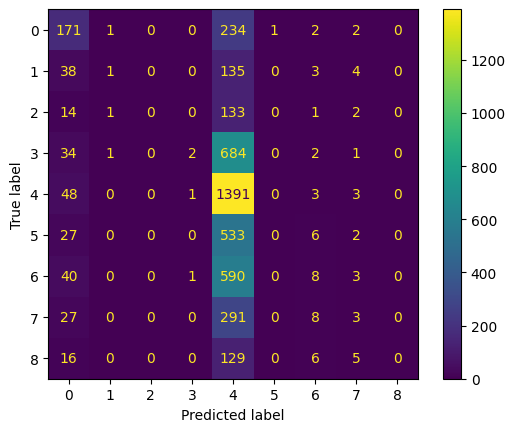

In [16]:
y_pred = []
y_true = []

with torch.no_grad():
    for images, genders, age_labels, ages in valloader:
        images, genders, age_labels, ages = images.to(device), genders.to(device), age_labels.to(device), ages.to(device)
        pred_age_ranges = age_range_model(images)
        y_pred.append(pred_age_ranges.cpu())
        y_true.append(age_labels.cpu())
    
y_pred = torch.stack(y_pred).view(-1, 9)
y_pred = torch.argmax(y_pred, dim = 1).view(-1)
y_true = torch.stack(y_true).view(-1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()
# [0, 6, 14, 25, 35, 50, 70]

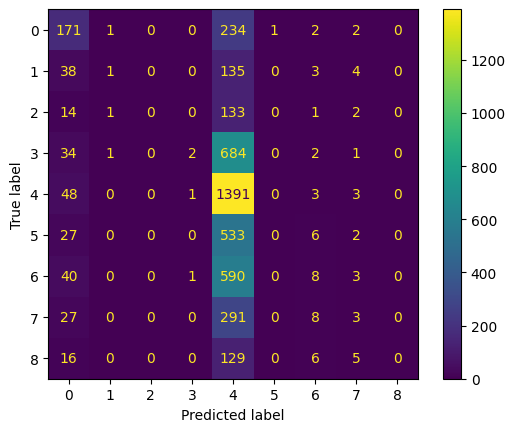

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig("confusion_matrix.png")

In [18]:
def visualize_history(history, save_history=True): 
    plt.figure(figsize = (20,8))
    plt.subplot(131)
    plt.plot(range(1, len(history['train_age_range_acc']) + 1), history['train_age_range_acc'], label = 'train_age_range_acc', c = 'r')
    plt.plot(range(1, len(history['val_age_range_acc']) + 1), history['val_age_range_acc'], label = 'val_age_range_acc', c = 'g')
    plt.plot(range(1, len(history['train_gender_acc']) + 1), history['train_gender_acc'], label = 'train_gender_acc', c = 'b')
    plt.plot(range(1, len(history['val_gender_acc']) + 1), history['val_gender_acc'], label = 'val_gender_acc', c = 'y')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Gender And Age Prediction Accuracy')
    plt.legend()

    plt.subplot(132)
    plt.plot(range(1, len(history['train_age_range_loss']) + 1), history['train_age_range_loss'], label = 'train_age_range_loss', c = 'r')
    plt.plot(range(1, len(history['val_age_range_loss']) + 1), history['val_age_range_loss'], label = 'val_age_range_loss', c = 'g')
    plt.plot(range(1, len(history['train_age_estimation_loss']) + 1), history['train_age_estimation_loss'], label = 'train_age_loss', c = 'b')
    plt.plot(range(1, len(history['val_age_estimation_loss']) + 1), history['val_age_estimation_loss'], label = 'val_age_loss', c = 'y')
    plt.title('Age Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Age Loss')
    plt.legend()

    
    plt.subplot(133)
    plt.plot(range(1, len(history['train_gender_loss']) + 1), history['train_gender_loss'], label = 'train_gender_loss', c = 'b')
    plt.plot(range(1, len(history['val_gender_loss']) + 1), history['val_gender_loss'], label = 'val_gender_loss', c = 'y')
    plt.title('Gender Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Gender Loss')
    plt.legend()
    
    if save_history:
        plt.savefig("results.png")


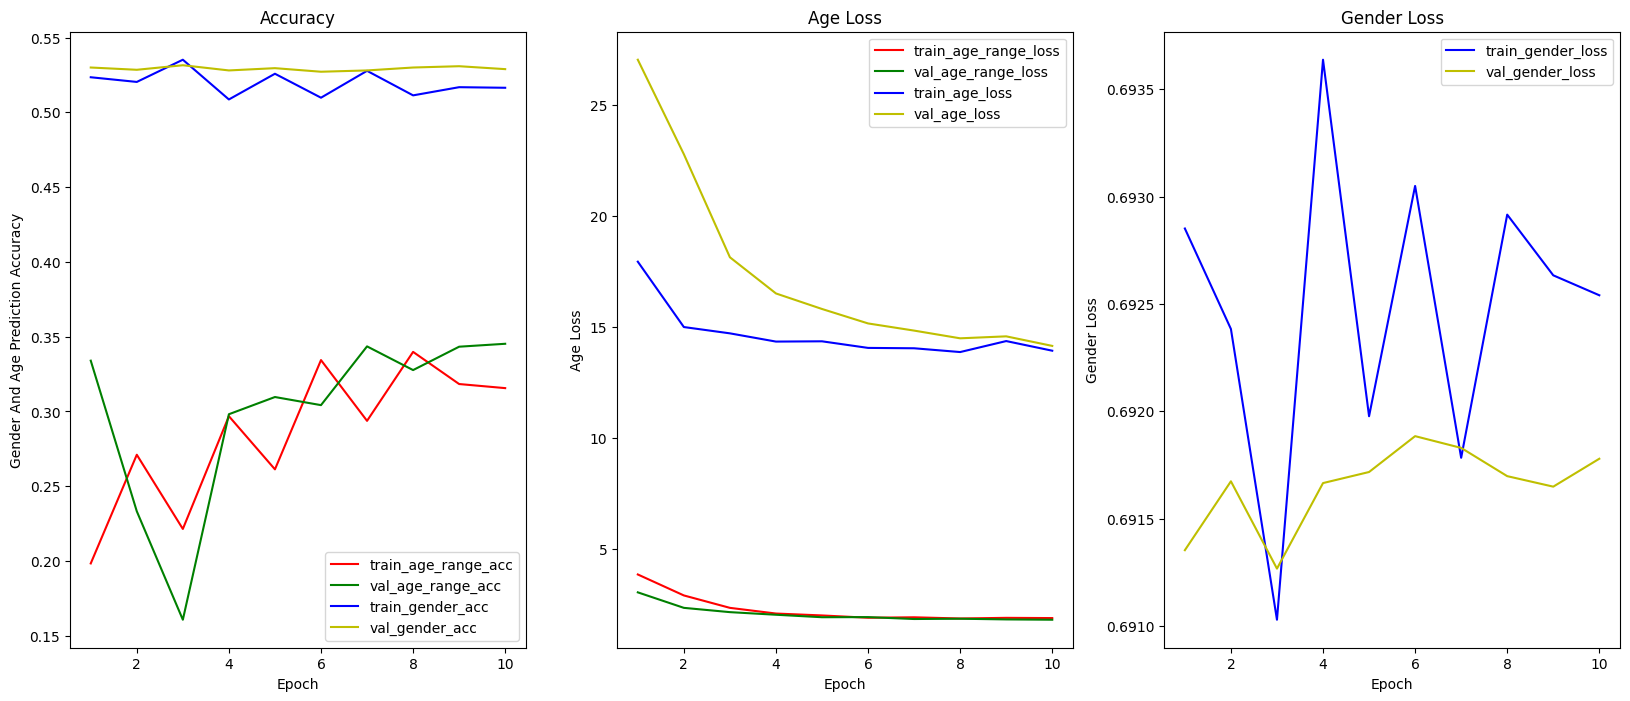

In [19]:
visualize_history(history, save_history=True)

In [20]:
os.listdir()


['vgg_face_torch.tar.gz.3',
 'vgg_face_torch.tar.gz.1',
 'confusion_matrix.png',
 'Dataset',
 'vgg_face_torch',
 'results.png',
 'vgg_face_torch.tar.gz',
 'vgg_face_torch.tar.gz.2',
 'practice.ipynb']